# Deep Age Estimation Using ResNet50 Architecture

# Content <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Loading](#load)
* [4. Exploratory Data Analysis](#eda)
    * [4.1 General Information](#info)
    * [4.2 Label Distribution](#distribution)
    * [4.3 Sample Image](#sample)
    * [4.4 Findings](#find)
* [5. Modeling](#procedure)
* [6. Script to Run on GPU](#normalization)
    * [6.1 Output](#output)
        * [6.1.1 Trial 1](#trial1)
        * [6.1.1 Trial 2](#trial2)
        * [6.1.1 Trial 3](#trial3)
* [7. Conclusions](#conclusions)

## Introduction <a id='intro'></a>

In order to improve the services to the customer, the owner of the store wants to know how old is their customer. There is a cctv on the top of the cashier that will capture the image of the customer. The primary objective is to estimate the age of the client. The deep learning approach will be used and employ ResNet50 architecture. The evaluation metric chosen for model performance is Mean Absolute Error (MAE), measuring the average absolute difference between predicted and actual ages.

## Initiation <a id='init'></a>

In [1]:
# Library for Dataset
import pandas as pd

# Library for Visualization
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow Library
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Data Loading <a id='load'></a>

In the data loading step, the required dataset is stored in the `/datasets/faces/` folder, containing two main components:

1. Image Files:

Located in the `final_files` folder, comprising 7,600 facial photos.

2. Labels:

Stored in the `labels.csv` file with two columns: `file_name` and `real_age`.

In [2]:
# Load the labels dataset
labels_path = '/datasets/faces/labels.csv'
labels_df = pd.read_csv(labels_path)
print(f"Number of images in the dataset:",len(labels_df))

Number of images in the dataset: 7591


## Exploratory Data Analysis <a id='eda'></a>

### General Information <a id='info'></a>

In [3]:
# Show general information
labels_df.info(), labels_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


(None,
           real_age
 count  7591.000000
 mean     31.201159
 std      17.145060
 min       1.000000
 25%      20.000000
 50%      29.000000
 75%      41.000000
 max     100.000000)

### Label Distribution <a id='distribution'></a>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


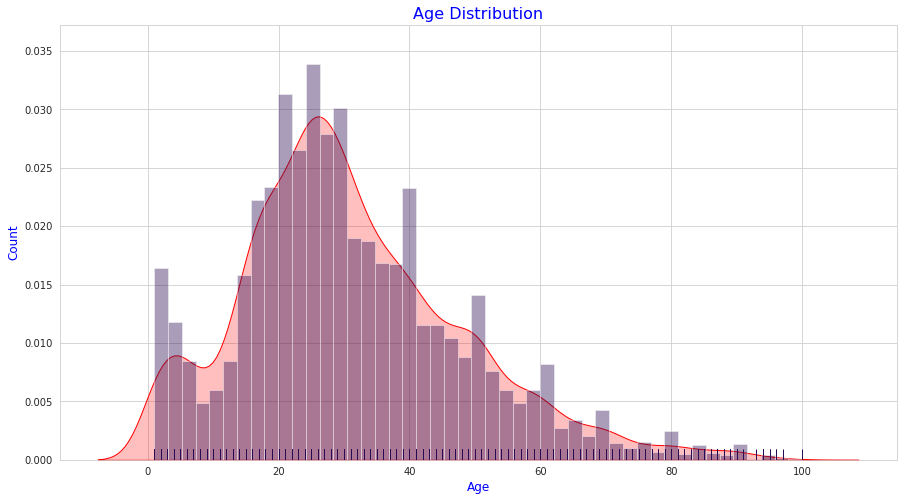

In [9]:
# Barplot of Distribution
plt.figure(figsize=(15, 8))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels_df['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Count', fontsize=12, color='b')
plt.title('Age Distribution', fontsize=16, color='b')
plt.show()

### Sample Image  <a id='sample'></a>

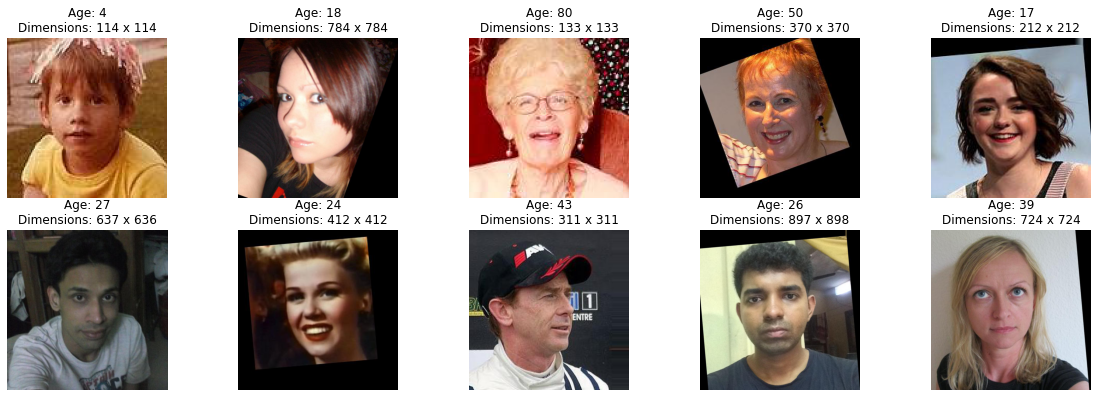

In [4]:
# Display sample photos for different ages with image dimensions
unique_ages = labels_df['real_age'].unique()
sample_ages = unique_ages[:15]

plt.figure(figsize=(20, 10))

for i, age in enumerate(sample_ages):
    plt.subplot(3, 5, i+1)
    sample_image_path = labels_df[labels_df['real_age'] == age]['file_name'].values[0]
    img_path = os.path.join('/datasets/faces/final_files/', sample_image_path)
    
    # Load the image
    img = Image.open(img_path)
    
    # Display image dimensions
    img_dimensions = f"{img.size[0]} x {img.size[1]}"
    
    plt.imshow(img)
    plt.title(f'Age: {age}\nDimensions: {img_dimensions}')
    plt.axis('off')

plt.show()

### Findings <a id='find'></a>

1. Age Range (1-100):

Impact on Model Training: A broad age range may challenge the model to effectively learn specific age patterns. Some ages may have significantly different facial features, affecting the model's ability to generalize.

2. Distribution:

5% of the observations have an age of 20 years or below. This represents the lower quartile. 50% of the observations have an age of 29 years or below. This represents the middle value or the second quartile. And 75% of the observations have an age of 41 years or below. This represents the upper quartile.

3. Diverse Photo Colors and Angles:

Impact on Model Training: Variation in photo color and angles may influence the model's ability to identify consistent facial features because of blocking. Models sensitive to such variations may require more data and augmentation techniques.

4. Varied Image Dimensions:

Impact on Model Training: Handling varied image dimensions requires effective preprocessing. The model should adapt to diverse image sizes, possibly necessitating adjustments in early layers.

5. General Implications:

Data Diversity: Ensuring representation across all age groups and facial variations is crucial for a reliable and generalizable model.

6. Data Processing and Augmentation:

Impact on Model Training: Data processing and augmentation, such as using ImageDataGenerator, are essential for handling color, angle, and dimension variations, enhancing model robustness.

## Modeling <a id='modeling'></a>

In the Modeling step, key functions are defined for processing on GPU:

1. load_train and load_test:

Functions to load and preprocess training and testing data using ImageDataGenerator for augmentation.

2. create_model:

Defines the architecture utilizing Keras ResNet50 for age prediction.

3. train_model:

Trains the model using the loaded training data with the function defined before. After that, the model created and trained with data flow generated.

In [ ]:
def load_train(path):
    """
    Load the training set from the specified path using flow_from_directory.
    """
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90
    )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_gen_flow

This `load_train` function performs the following tasks:

- Reads the labels from the `labels.csv` file.

- Utilizes an ImageDataGenerator for data augmentation, including rescaling, horizontal and vertical flips, and rotation.

- Creates a `flow_from_dataframe` generator using the specified directory, file names, and real ages.

- Resizes images to a target size of (224, 224) and sets a batch size of 32.

- Configures the generator for regression (*class_mode=raw*) and defines a training subset using the validation_split parameter.

- Returns the training generator (*train_gen_flow*) for further use in model training.

In [ ]:
def load_test(path):
    """
    Load the validation set/test set from the specified path using flow_from_directory.
    """
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow


The `load_test` function performs the following tasks:

- Reads the labels from the 'labels.csv' file.

- Uses an `ImageDataGenerator` for data preprocessing, including rescaling.

- Creates a `flow_from_dataframe` generator for the validation/test set using the specified directory, file names, and real ages.

- Resizes images to a target size of (224, 224) and sets a batch size of 32.

- Configures the generator for regression (*class_mode='raw'*) and defines a validation subset using the validation_split parameter.

- Returns the validation/test generator (*test_gen_flow*) for further use in model evaluation.

In [ ]:
def create_model(input_shape):
    
    """
    This code define the model architecture
    """
    resnet = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(resnet)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer = optimizer, loss='mse', metrics=['mae'])
    
    model.summary()
    
    return model

The `create_model` function outlines the following steps to define the model architecture:

- Initializes a ResNet50 base with pre-trained ImageNet weights and excludes the top layer.

- Constructs a Sequential model.

- Adds the ResNet50 base to the model.

- Introduces a Dropout layer with a 20% dropout rate for regularization.

- Applies Global Average Pooling to reduce spatial dimensions.

- Adds a Dense layer with a single neuron and ReLU activation for regression.

- Configures the model with the Adam optimizer, mean squared error (mse) loss, and mean absolute error (mae) metric.

- Prints the model summary.

- Returns the compiled model for further use in training.

The architecture incorporates transfer learning with ResNet50 for feature extraction and regression for age prediction.

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Train model using specified parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, validation_data=test_data, 
              batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=1)
    
    return model

The `train_model` function performs the following tasks:

- Checks if steps_per_epoch and validation_steps are specified; if not, sets them to the length of the corresponding datasets.

- Utilizes the fit method to train the model with the specified training and testing/validation data.

- Incorporates parameters such as batch size, epochs, steps per epoch, and validation steps.

- Returns the trained model for further evaluation or prediction.

- This function streamlines the training process by fitting the model to the training data and validating it on the test data, adhering to the specified parameters.

## Script to Run on GPU <a id='gpu'></a>

In this step, a script for GPU execution is created, incorporating functions defined earlier. The script facilitates the process of running the computer vision project on GPU platforms, utilizing key functions for data loading, model creation, and training.

In [ ]:
# Prepare script to run on GPU platform

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
"""

import inspect

# Write the script to a file
with open('computer_vision_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')

    # Write the function definitions
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

    # Add your script here for loading data, creating the model, and training the model
    f.write("""

# Specify the path to your dataset
dataset_path = '/datasets/faces/'

# Load the training and test sets
train_data = load_train(dataset_path)
test_data = load_test(dataset_path)

# Create the model
input_shape = (224, 224, 3) 
model = create_model(input_shape)

# Train the model
batch_size = 32
steps_per_epoch = len(train_data)
validation_steps = len(test_data)

trained_model = train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)
""")

Now run the notebook created using GPU.

### Output <a id='output'></a>

#### Trial 1 <a id='trial1'></a>

Using Learning Rate 0.0001

#### Trial 2 <a id='trial2'></a>

Add 1 layer and tune the learning rate to 0.00001

#### Trial 3 <a id='trial3'></a>

1. Remove the additional layer
2. Add Dropout layer to prevent overfitting
3. Tune learning rate to 0.0003
4. Increase batch size to 32

## Conclusions <a id='conclusions'></a>

In conclusion, the findings from the Exploratory Data Analysis (EDA) phase provided valuable insights into the dataset's age distribution and characteristics. The average age of approximately 31.2 years, a standard deviation of 17.1 years, and quartile information highlighted the dataset's diversity. The presence of images with obstructed faces like blocked part of face, brightnes, etc adds a complexity to the age detection task.

Moving to the output of the model training phase, several key observations guide the model development process. The inverse relationship between learning rate and overfitting suggests a delicate balance in training hyperparameters. In other words, lower learning rate resulting overfitting and vice versa. The impact of batch size on training speed emphasizes the trade-off between computational efficiency and model generalization. Introducing dropout after the ResNet backbone emerges as a beneficial strategy to enhance model performance (lower mean absolute error on validation data). But remain overfitting issues.

The best Mean Absolute Error (MAE) achieved in trial 3 further underscores the significance of these considerations. In conclusion, ResNet50 has proven to be a valuable backbone for age estimation models. However, the exploration of alternative image preprocessing techniques such as Pillow, OpenCV, and other model architectural remains crucial.